In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")


In [5]:
def load_and_preprocess_data(file_path, lookback_days=30):    
    data = pd.read_csv("Google_Stock_Price_Train.csv")        
    print("Column names in dataset:", data.columns)   
    expected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    data = data[expected_columns]   
    for col in expected_columns:
        data[col] = data[col].replace({',': ''}, regex=True).astype(float)    
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)    
    X, y = [], []
    for i in range(lookback_days, len(data_scaled)):
        X.append(data_scaled[i - lookback_days:i])
        y.append(data_scaled[i, 3])   
    X, y = np.array(X), np.array(y)
    return X, y, scaler, data
file_path = 'Google_Stock_Price_Train.csv'  
lookback_days = 30
X, y, scaler, data = load_and_preprocess_data(file_path, lookback_days=lookback_days)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)



Column names in dataset: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


1.Select the required columns  
2.Remove commas and convert columns to float  
3.Standardize data  Prepare time-series data  
4.Split data into training, validation, and test sets

In [8]:
def build_lstm_model(input_shape, units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Predict closing price
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')  # Changed filename to .keras
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

 
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(np.concatenate([np.zeros((y_pred_scaled.shape[0], data.shape[1] - 1)), y_pred_scaled], axis=1))[:, -1]
def mean_directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1]))
mda_score = mean_directional_accuracy(y_test, y_pred)
print("Mean Directional Accuracy:", mda_score)



Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7455 - mae: 0.5965 - val_loss: 0.0266 - val_mae: 0.1372
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1056 - mae: 0.2030 - val_loss: 0.0330 - val_mae: 0.1609
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1280 - mae: 0.2030 - val_loss: 0.0240 - val_mae: 0.1169
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0831 - mae: 0.1592 - val_loss: 0.0329 - val_mae: 0.1263
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0536 - mae: 0.1412 - val_loss: 0.0238 - val_mae: 0.1305
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0801 - mae: 0.1628 - val_loss: 0.0258 - val_mae: 0.1112
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0487 - mae: 0.1411 - val_loss: 0.0369 - val_mae: 0.1701
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0563 - mae: 0.1533 - val_loss: 0.0231 - val_mae: 0.1203
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - lo

1.Build LSTM model     
2.Set model input shape       
3.Define callbacks for early stopping and model checkpointing       
4.Train the model     
5.Evaluate the model   
6.Predict and inverse scale    
7.Calculate Mean Directional Accuracy (MDA)

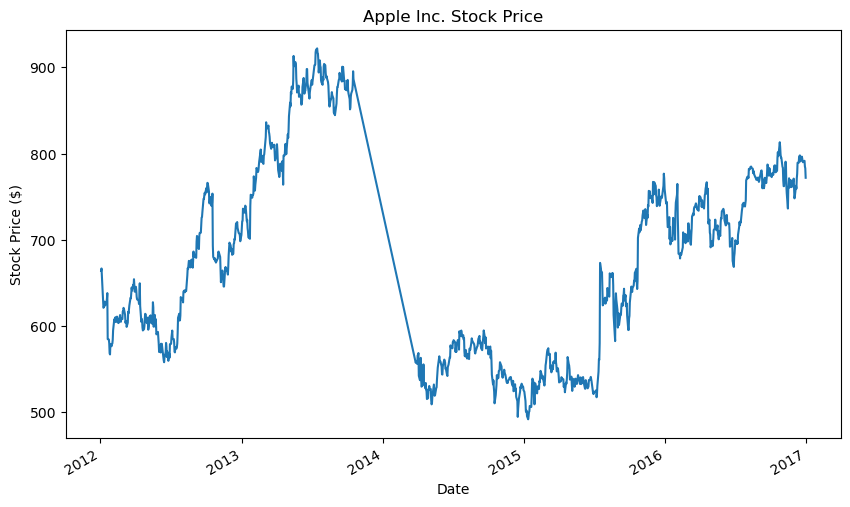

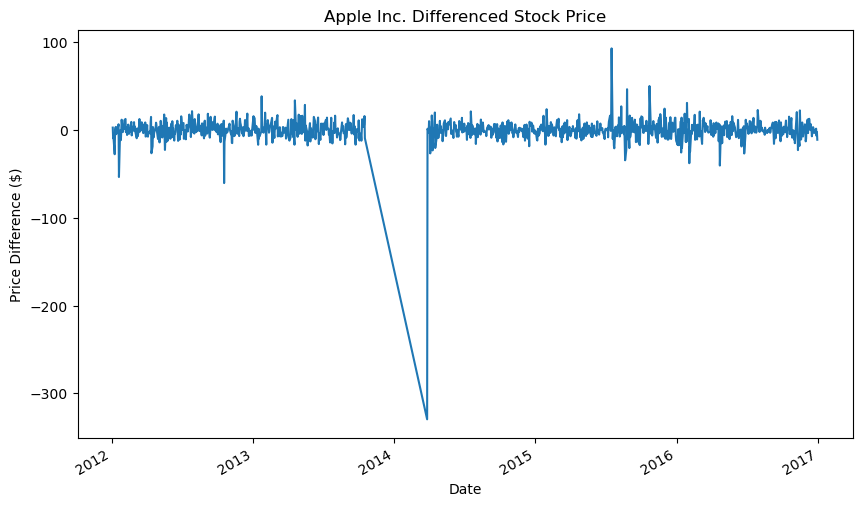

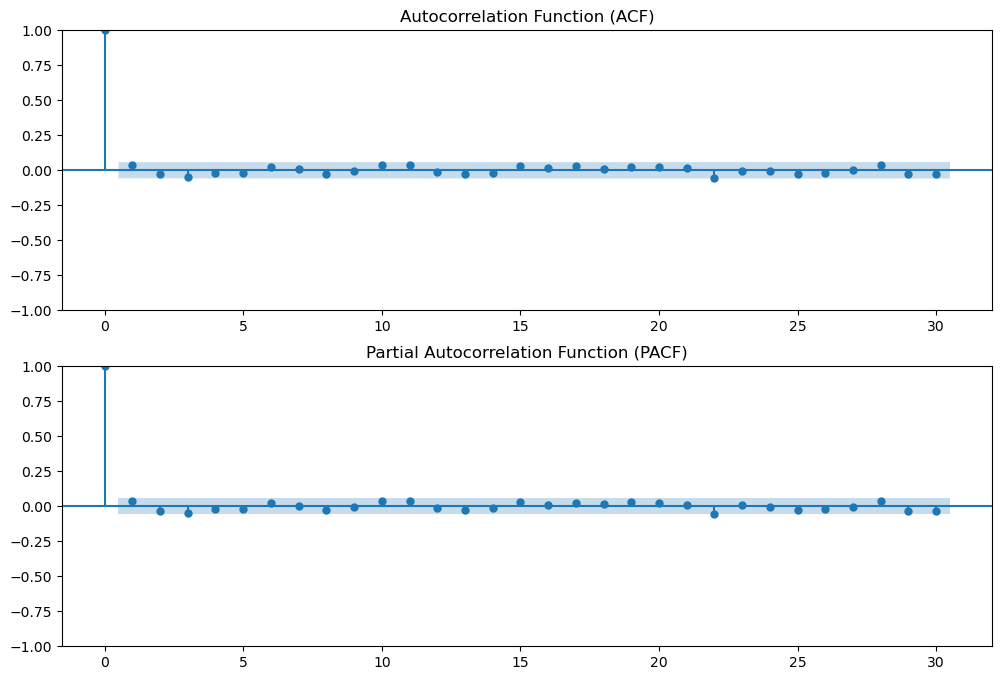

In [9]:
file_path = 'Google_Stock_Price_Train.csv'
stock_data = pd.read_csv(file_path)
stock_data['Close'] = pd.to_numeric(stock_data['Close'], errors='coerce')
stock_data.dropna(subset=['Close'], inplace=True)
if 'Date' in stock_data.columns:
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data.set_index('Date', inplace=True)

stock_data['Close'].plot(figsize=(10, 6), title='Apple Inc. Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.show()
stock_data['Close_diff'] = stock_data['Close'].diff()
stock_data.dropna(inplace=True)
stock_data['Close_diff'].plot(figsize=(10, 6), title='Apple Inc. Differenced Stock Price')
plt.xlabel('Date')
plt.ylabel('Price Difference ($)')
plt.show()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(stock_data['Close_diff'], lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(stock_data['Close_diff'], lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.show()




1.Ensure 'Close' is numeric and drop any non-numeric rows             
2.Convert 'Date' column to datetime and set it as index if it's available          
3.Plot original stock price      
4. Differencing and plotting ACF/PACF

In [10]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)


Sequence creation function

In [11]:
data_diff = stock_data['Close_diff'].values.reshape(-1, 1)
scaler_diff = MinMaxScaler()
data_diff_normalized = scaler_diff.fit_transform(data_diff)
train_size_diff = int(len(data_diff_normalized) * 0.8)
train_data_diff, test_data_diff = data_diff_normalized[:train_size_diff], data_diff_normalized[train_size_diff:]
seq_length = 40
X_train_diff = create_sequences(train_data_diff, seq_length)
X_test_diff = create_sequences(test_data_diff, seq_length)
y_train_diff = train_data_diff[seq_length:]
y_test_diff = test_data_diff[seq_length:]




1.Differencing and normalization  
2.Split data into training and testing   
3.Sequence length for RNN 

In [12]:
model = Sequential()
model.add(SimpleRNN(units=50, activation='tanh', input_shape=(X_train_diff.shape[1], 1)))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_diff, y_train_diff, epochs=20, batch_size=32, validation_data=(X_test_diff, y_test_diff))
model2 = Sequential()
model2.add(SimpleRNN(units=100, activation='tanh', input_shape=(X_train_diff.shape[1], 1), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(SimpleRNN(units=50, activation='tanh', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(SimpleRNN(units=25, activation='tanh'))
model2.add(Dropout(0.2))
model2.add(Dense(units=1, activation='linear'))
model2.compile(optimizer='adam', loss='mean_squared_error')
history2 = model2.fit(X_train_diff, y_train_diff, epochs=20, batch_size=32, validation_data=(X_test_diff, y_test_diff))


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1664 - val_loss: 0.0053
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 6.3626e-04
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 4.6843e-04
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 4.7215e-04
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 4.5773e-04
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 4.5451e-04
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 4.9931e-04
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1119e-04 - val_loss: 4.5243e-04
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 4.9383e-04
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 6.3871e-04
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 5.5245e-04
Epoch 12/20
28/28 ━━━━━━━━━━━

1.Simple RNN model   
2.Improved RNN model with additional layers and dropout

In [13]:
gru_model = Sequential()
gru_model.add(GRU(units=128, activation='tanh', input_shape=(X_train_diff.shape[1], 1), return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=64, activation='tanh'))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=1, activation='linear'))
optimizer = Adam(learning_rate=0.0001, clipvalue=0.5)
gru_model.compile(optimizer=optimizer, loss='mean_squared_error')
history_gru = gru_model.fit(X_train_diff, y_train_diff, epochs=50, batch_size=64, validation_data=(X_test_diff, y_test_diff))
y_pred_diff = model2.predict(X_test_diff)
y_pred_improved = scaler_diff.inverse_transform(y_pred_diff)
y_actual_improved = scaler_diff.inverse_transform(y_test_diff)
mse = mean_squared_error(y_actual_improved, y_pred_improved)
mae = mean_absolute_error(y_actual_improved, y_pred_improved)
rmse = np.sqrt(mse)
r2 = r2_score(y_actual_improved, y_pred_improved)
percentage_error = np.mean(np.abs((y_actual_improved - y_pred_improved) / y_actual_improved)) * 100
medae = median_absolute_error(y_actual_improved, y_pred_improved)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared (R2) Score: {r2}')
print(f'Percentage Error: {percentage_error}%')
print(f'Median Absolute Error: {medae}')


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.6954 - val_loss: 0.4193
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.3550 - val_loss: 0.1706
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1363 - val_loss: 0.0321
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0249 - val_loss: 4.3245e-04
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0091 - val_loss: 0.0024
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0097 - val_loss: 3.9924e-04
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0095 - val_loss: 6.5002e-04
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0077 - val_loss: 4.6200e-04
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0077 - val_loss: 4.7678e-04
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0086 - val_loss: 4.4340e-04
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0088 - val_loss: 4.1450e-04
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━

GRU model

In [16]:
sequence_length = 10
prices = stock_data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
prices_normalized = scaler.fit_transform(prices)
train_data, test_data = prices_normalized[:int(len(prices_normalized) * 0.8)], prices_normalized[int(len(prices_normalized) * 0.8):]
X_train = create_sequences(train_data, sequence_length)
X_test = create_sequences(test_data, sequence_length)
y_train = train_data[sequence_length:]
y_test = test_data[sequence_length:]

bi_lstm_model_original = Sequential()
bi_lstm_model_original.add(Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True), input_shape=(sequence_length, 1)))
bi_lstm_model_original.add(Dropout(0.2))
bi_lstm_model_original.add(Bidirectional(LSTM(units=64, activation='tanh')))
bi_lstm_model_original.add(Dropout(0.2))
bi_lstm_model_original.add(Dense(units=1, activation='linear'))
optimizer = Adam(learning_rate=0.001, clipvalue=0.5)
bi_lstm_model_original.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_bi_lstm_original = bi_lstm_model_original.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0804 - val_loss: 0.0234
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0118 - val_loss: 0.0012
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0062 - val_loss: 0.0015
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0061 - val_loss: 0.0012
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0061 - val_loss: 0.0014
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0041 - val_loss: 9.6308e-04
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0056 - val_loss: 9.2415e-04
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - l

Bi-LSTM model

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


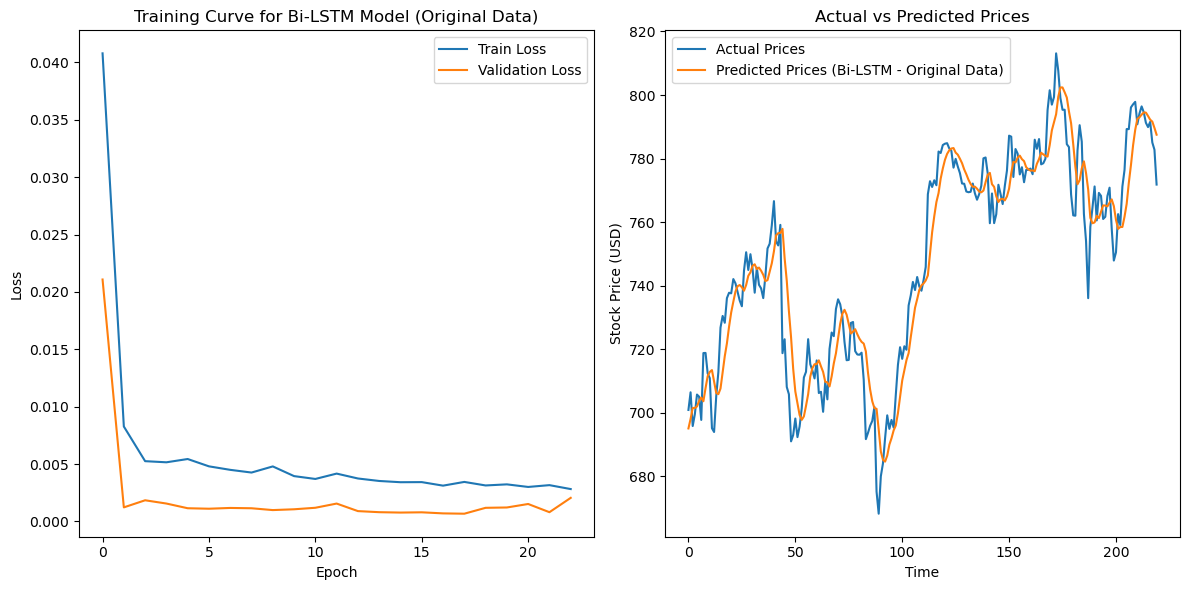

In [15]:
y_pred_bi_lstm_original = bi_lstm_model_original.predict(X_test)
y_pred_original = scaler.inverse_transform(y_pred_bi_lstm_original.reshape(-1, 1))
y_actual_original = scaler.inverse_transform(y_test)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_bi_lstm_original.history['loss'], label='Train Loss')
plt.plot(history_bi_lstm_original.history['val_loss'], label='Validation Loss')
plt.title('Training Curve for Bi-LSTM Model (Original Data)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_actual_original, label='Actual Prices')
plt.plot(y_pred_original, label='Predicted Prices (Bi-LSTM - Original Data)')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()

plt.tight_layout()
plt.show()

Plotting and prediction visualization

In [47]:
loss_bi_lstm_original = bi_lstm_model_original.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set (Bi-LSTM - Original Data): {loss_bi_lstm_original}')
percentage_error_bi_lstm_original = np.mean(np.abs((y_actual_original - y_pred_original) / y_actual_original)) * 100
print(f'Percentage Error (Bi-LSTM - Original Data): {percentage_error_bi_lstm_original}%')


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3175e-04 
Mean Squared Error on Test Set (LSTM - Original Data): 0.000612646690569818
Percentage Error (LSTM - Original Data): 1.0898976108096292%


Additional error metrics

In [17]:
file_path = 'Google_Stock_Price_Train.csv'
stock_data = pd.read_csv(file_path)
print("Initial data shape:", stock_data.shape)
print("\nFirst few rows of data:")
print(stock_data.head())
print("\nColumns:", stock_data.columns.tolist())
print("\nData types:")
print(stock_data.dtypes)



Initial data shape: (1258, 6)

First few rows of data:
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800

Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

Data types:
Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object


Print initial data info for debugging

In [18]:

numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
available_columns = [col for col in numeric_columns if col in stock_data.columns]
if not available_columns:
    raise ValueError(f"None of the required columns {numeric_columns} found in the dataset")



Convert data types and handle missing values  
Check if columns exist in the dataset

In [19]:

def convert_to_numeric(series):
    if series.dtype == object: 
        cleaned = series.replace('[\$,\s]', '', regex=True)
        return pd.to_numeric(cleaned, errors='coerce')
    else:  
        return series



Improved numeric conversion function

In [20]:
for col in available_columns:
    stock_data[col] = convert_to_numeric(stock_data[col])
print("\nData types after conversion:")
print(stock_data[available_columns].dtypes)
print("\nMissing values after conversion:")
print(stock_data[available_columns].isnull().sum())



Data types after conversion:
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

Missing values after conversion:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


Convert to numeric and handle missing values       
Print info after conversion

In [21]:
stock_data.dropna(subset=available_columns, inplace=True)
if len(stock_data) == 0:
    raise ValueError("No data remaining after cleaning. Please check your input data.")
print(f"\nFinal data shape after cleaning: {stock_data.shape}")




Final data shape after cleaning: (1258, 6)


 Drop rows with missing values               
Verify we have data after cleaning

In [22]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(stock_data[available_columns])
seq_length = 30  
train_ratio = 0.8
val_ratio = 0.1


total_data = len(scaled_data)
train_size = int(total_data * train_ratio)
val_size = int(total_data * val_ratio)
test_size = total_data - train_size - val_size

 
if train_size < seq_length or val_size < seq_length or test_size < seq_length:
    raise ValueError(f"Not enough data for the chosen sequence length ({seq_length})")


train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]



Normalize the data   
Split the data into training, validation, and test sets    
Calculate dataset sizes
Ensure we have enough data for all splits

In [23]:
def create_multivariate_sequences(data, seq_length, pred_steps):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_steps + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length:i + seq_length + pred_steps, :])
    return np.array(X), np.array(y)


pred_steps = 1
X_train, y_train = create_multivariate_sequences(train_data, seq_length, pred_steps)
X_val, y_val = create_multivariate_sequences(val_data, seq_length, pred_steps)
X_test, y_test = create_multivariate_sequences(test_data, seq_length, pred_steps)


y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)


print("\nDataset splits:")
print(f"Training sequences: {len(X_train)}")
print(f"Validation sequences: {len(X_val)}")
print(f"Test sequences: {len(X_test)}")




Dataset splits:
Training sequences: 976
Validation sequences: 95
Test sequences: 97


Create sequences  
Reshape target variables    
Print dataset information

In [24]:
if len(X_train) > 0 and len(X_val) > 0 and len(X_test) > 0:
    lstm_model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
        Dropout(0.2),
        LSTM(64, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(y_train.shape[1], activation='linear')
    ])

    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    

Build and train model only if we have sufficient data

In [25]:
    
    history = lstm_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=1
    )

    

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0593 - val_loss: 0.0132
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0101 - val_loss: 0.0021
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0069 - val_loss: 0.0011
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0060 - val_loss: 0.0015
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0053 - val_loss: 9.9133e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0046 - val_loss: 0.0010
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0047 - val_loss: 0.0019


Train the model

In [26]:
    y_pred = lstm_model.predict(X_test)    
    y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1]))
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))    
    close_price_index = available_columns.index('Close')
    mse = mean_squared_error(y_test_inverse[:, close_price_index], y_pred_inverse[:, close_price_index])
    mae = mean_absolute_error(y_test_inverse[:, close_price_index], y_pred_inverse[:, close_price_index])
    r2 = r2_score(y_test_inverse[:, close_price_index], y_pred_inverse[:, close_price_index])
    percentage_error = np.mean(np.abs((y_test_inverse[:, close_price_index] - y_pred_inverse[:, close_price_index]) 
                                    / y_test_inverse[:, close_price_index])) * 100

    print("\nModel Performance Metrics:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Percentage Error: {percentage_error:.2f}%")
    

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step

Model Performance Metrics:
Mean Squared Error: 491.3709
Mean Absolute Error: 19.6002
R2 Score: -1.6270
Percentage Error: 2.51%


Evaluate and plot results  
Reverse scaling for evaluation
Calculate metrics for the "Close" price

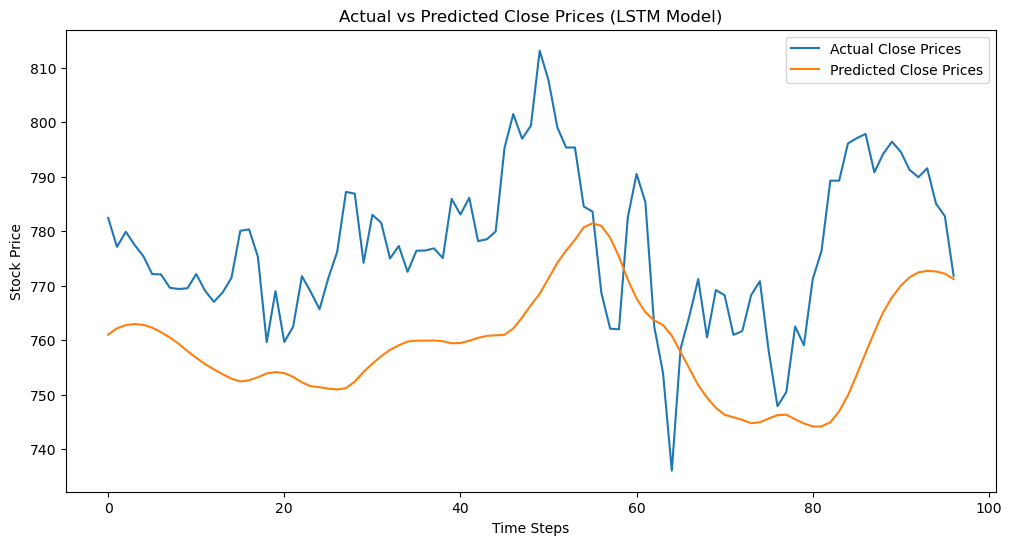

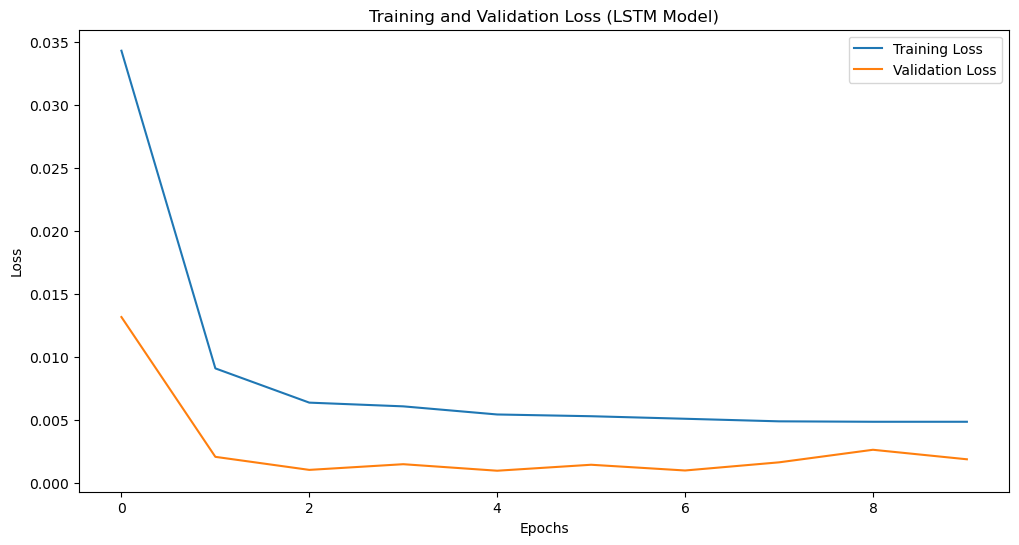

In [27]:
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inverse[:, close_price_index], label='Actual Close Prices')
    plt.plot(y_pred_inverse[:, close_price_index], label='Predicted Close Prices')
    plt.title("Actual vs Predicted Close Prices (LSTM Model)")
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training and Validation Loss (LSTM Model)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    

Plot predictions vs actual prices   
Plot training history